# NLP Automatic Ticket Assignment Project


In [336]:
# !pip install chart_studio
# !pip install wordcloud
# !pip install ftfy

# Standard Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS
from ftfy import *

from utils.visualization import *
from utils.datapreprocessing import *

In [337]:
filename= "dataset/input_data.xlsx"
df = pd.read_excel(filename, lines=True)

In [338]:
df.head(5)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [339]:
df.count()

Short description    8492
Description          8499
Caller               8500
Assignment group     8500
dtype: int64

In [340]:
# Convert datatype to string
df = df.applymap(str)
df.count()

Short description    8500
Description          8500
Caller               8500
Assignment group     8500
dtype: int64

In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
Short description    8500 non-null object
Description          8500 non-null object
Caller               8500 non-null object
Assignment group     8500 non-null object
dtypes: object(4)
memory usage: 265.7+ KB


In [342]:
df['Assignment group'].value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
GRP_2      241
GRP_19     215
GRP_3      200
GRP_6      184
GRP_13     145
GRP_10     140
GRP_5      129
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4      100
GRP_29      97
GRP_18      88
GRP_16      85
GRP_17      81
GRP_31      69
GRP_7       68
GRP_34      62
GRP_26      56
GRP_40      45
GRP_28      44
GRP_41      40
GRP_15      39
GRP_30      39
GRP_42      37
          ... 
GRP_44      15
GRP_36      15
GRP_50      14
GRP_65      11
GRP_53      11
GRP_52       9
GRP_51       8
GRP_55       8
GRP_49       6
GRP_59       6
GRP_46       6
GRP_43       5
GRP_32       4
GRP_66       4
GRP_58       3
GRP_63       3
GRP_38       3
GRP_68       3
GRP_56       3
GRP_54       2
GRP_69       2
GRP_57       2
GRP_72       2
GRP_71       2
GRP_61       1
GRP_67       1
GRP_64       1
GRP_73       1
GRP_35       1
GRP_70       1
Name: Assignment group, Length: 74, dtype: int64

In [343]:
# Drop Rows if Description is null
df = df[~df['Description'].isnull()]

In [344]:
# Concatenate Short description and Description
df['Complete_Description'] = df['Description'] + " " + df['Short description']
df.head(10)

,Short description,Description,Caller,Assignment group,Complete_Description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,-verified user details.(employee# & manager na...
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool page unable to access...
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,unable to log in to engineering tool and skype...
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,event: critical:HostName_221.company.com the v...
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0,ticket_no1550391- employment status - new non-...
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,unable to disable add ins on outlook unable to...
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0,ticket update on inplant_874773 ticket update ...


## Visualization

#### Word Cloud of "Short descrition" Column

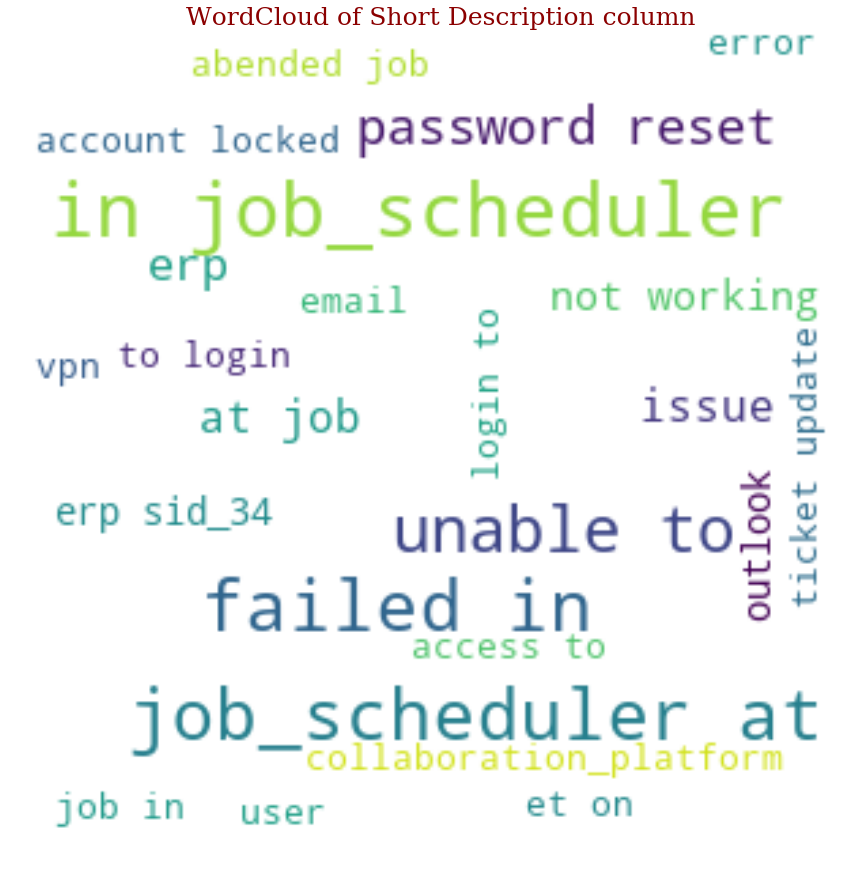

In [345]:
word_cloud_visulization(df['Short description'], "Short Description", stopword=True)

#### Word Cloud of "Description" Column

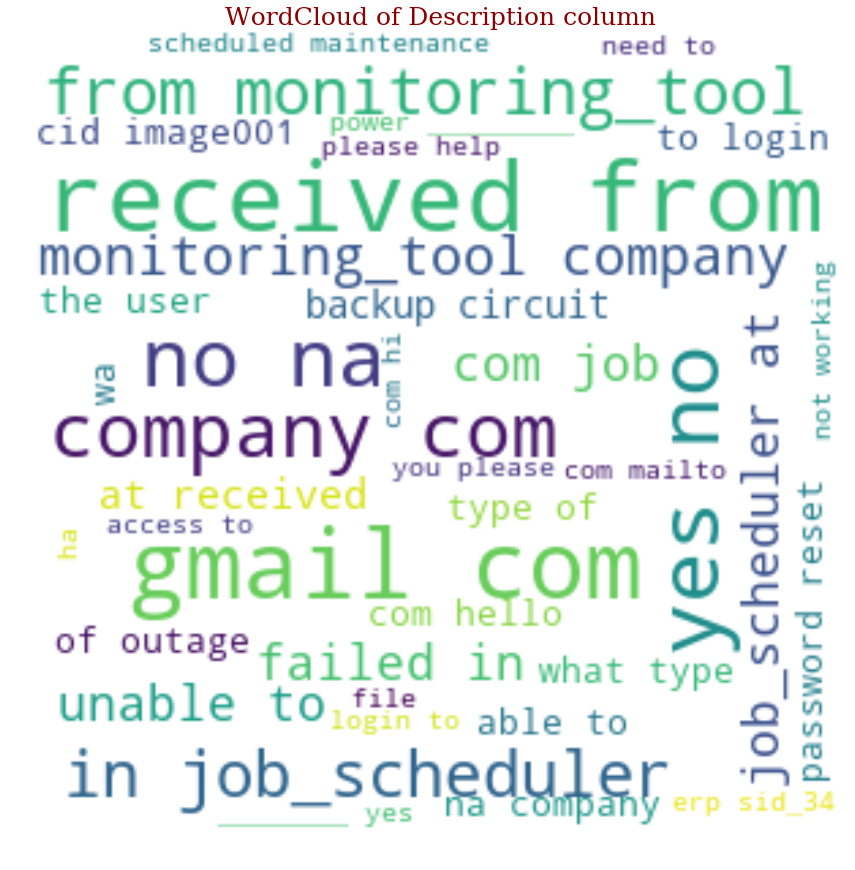

In [346]:
word_cloud_visulization(df['Description'], "Description", stopword=True)

#### Word Cloud of "Complete Description" Column

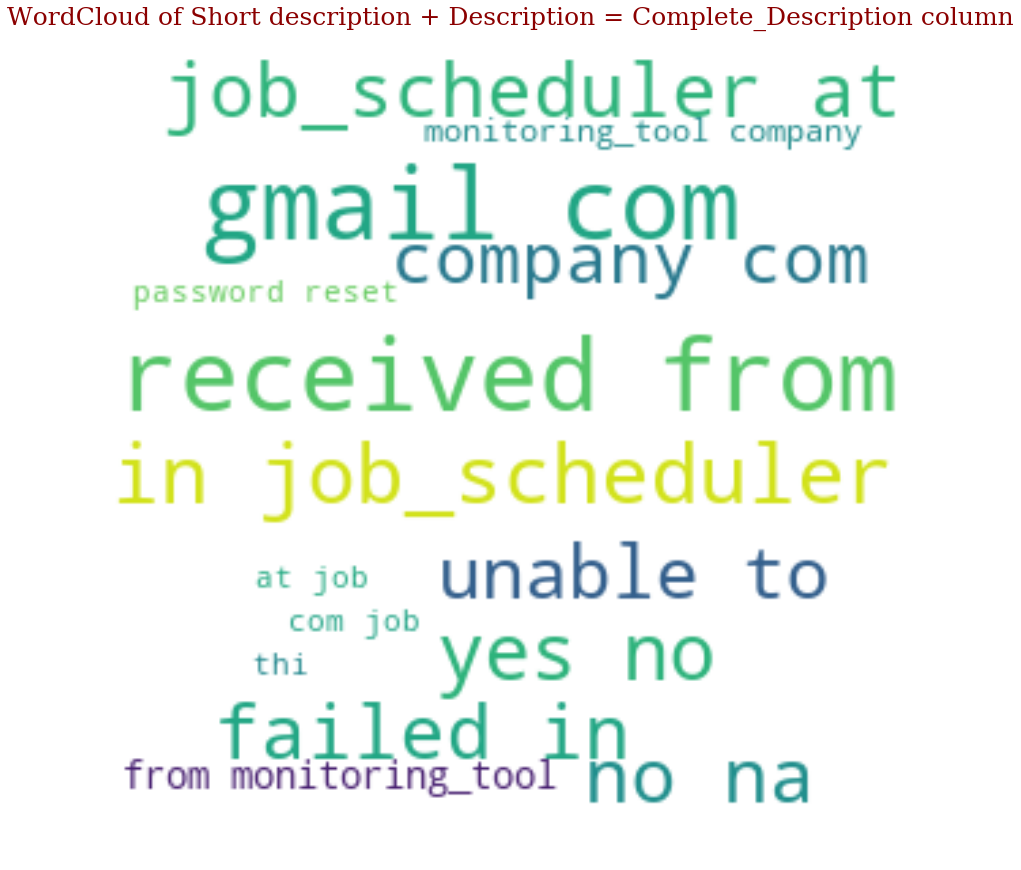

In [347]:
# Concatenate Short description + Description = Complete_Description
word_cloud_visulization(df['Complete_Description'], "Short description + Description = Complete_Description", stopword=True)

#### Word Cloud of "Caller" Column

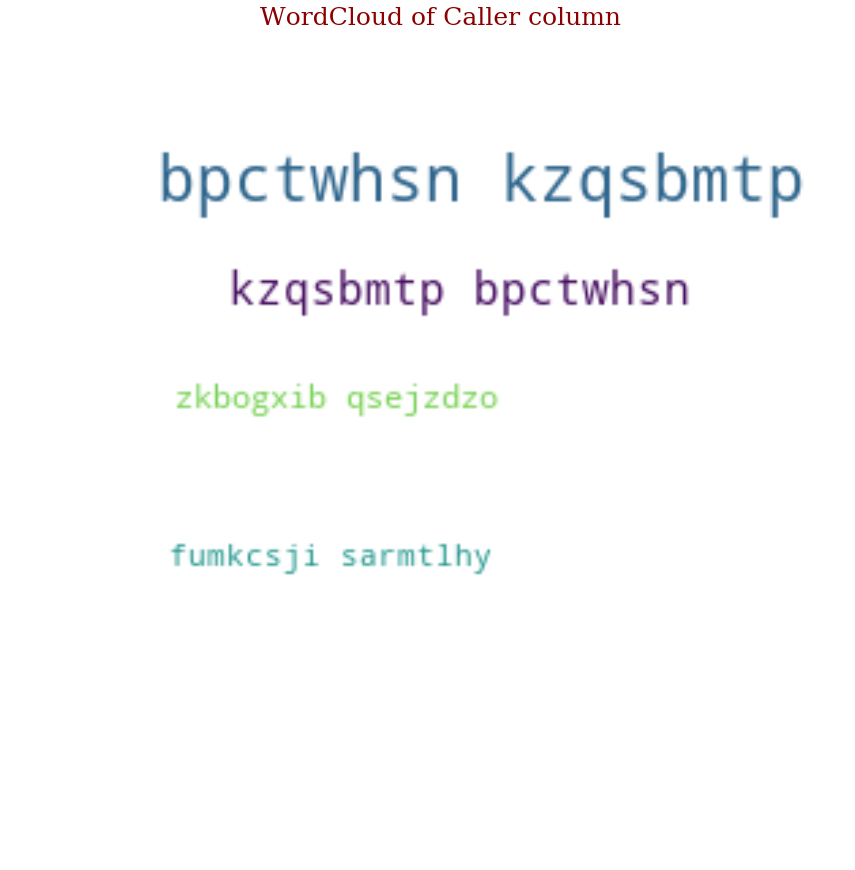

In [348]:
word_cloud_visulization(df['Caller'], "Caller", stopword=True)

## Datapreprocessing

In [349]:
# clean the dataset from Mojibakes using ftfy
df['Complete_Description'][164]

'\n\nreceived from: abcdri@company.com\n\nwindy shi å°†æ’¤å›žé‚®ä»¶"ticket_no1564867 -- comments added"ã€‚\n\n\næœ¬è®¯æ\x81¯ä»…ä¾›æŒ‡å®šçš„æŽ¥æ”¶äººä½¿ç”¨ï¼Œå…¶ä¸\xadå\x8f¯èƒ½åŒ…å\x90«é€‚ç”¨æ³•å¾‹é¡¹ä¸‹ç‰¹è®¸çš„ã€\x81ä¿\x9då¯†çš„å’Œç¦\x81æ\xad¢æŠ«éœ²çš„å†…å®¹ã€‚é™¤æŒ‡å®šçš„æŽ¥æ”¶äººå¤–ï¼Œä¸¥ç¦\x81å…¶ä»–ä»»ä½•äººä¼\xa0æ’\xadã€\x81åˆ†å\x8f‘æˆ–å¤\x8dåˆ¶æœ¬è®¯æ\x81¯ã€‚å¦‚æžœæ‚¨è¯¯æ”¶åˆ°æœ¬è®¯æ\x81¯ï¼Œè¯·é€šçŸ¥å\x8f‘ä»¶äººå¹¶å°†è®¯æ\x81¯åˆ\xa0é™¤ã€‚\n[\nselect the following link to view the disclaimer in an alternate language.  æ’¤å›ž: ticket_no1564867 -- comments added'

In [350]:
df['Short description'] = df['Short description'].apply(fix_text)
df['Description'] = df['Description'].apply(fix_text)
df['Complete_Description'] = df['Complete_Description'].apply(fix_text)

In [351]:
df['Complete_Description'][164]

'\n\nreceived from: abcdri@company.com\n\nwindy shi 将撤回邮件"ticket_no1564867 -- comments added"。\n\n\n本讯息仅供指定的接收人使用,其中可能包含适用法律项下特许的、保密的和禁止披露的内容。除指定的接收人外,严禁其他任何人传播、分发或复制本讯息。如果您误收到本讯息,请通知发件人并将讯息删除。\n[\nselect the following link to view the disclaimer in an alternate language.  撤回: ticket_no1564867 -- comments added'

In [352]:
# Clean dataset cloumn Complete_Description

cleanDataset(df, 'Complete_Description', getRegexList())

,Short description,Description,Caller,Assignment group,Complete_Description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,verified user details employee manager name ...
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,from hello team meetings skype meetings etc...
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,from cannot log to vpn best cant log to vpn
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable access tool page unable access tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,unable log to engineering tool and skype unabl...
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,event critical hostname company com the value...
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0,ticket employment status new non employee ent...
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,unable disable add ins outlook unable disable ...
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0,ticket update inplant ticket update inplant


In [353]:
df.head()

,Short description,Description,Caller,Assignment group,Complete_Description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,verified user details employee manager name ...
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,from hello team meetings skype meetings etc...
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,from cannot log to vpn best cant log to vpn
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable access tool page unable access tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error


In [354]:
# Adding Word count and Description Length
df['review_len'] = df['Complete_Description'].astype(str).apply(len)
df['word_count'] = df['Complete_Description'].apply(lambda x: len(str(x).split()))

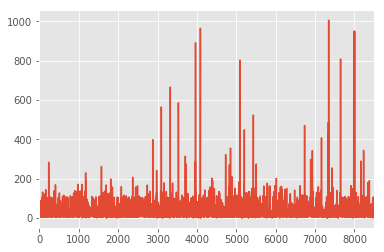

In [355]:
# Word Count Distribution for Description
df['word_count'].plot(
    x='word_count',
    y='count')

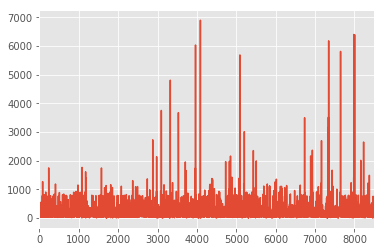

In [356]:
# Description Length Distribution
df['review_len'].plot(
    x='review length',
    y='count')

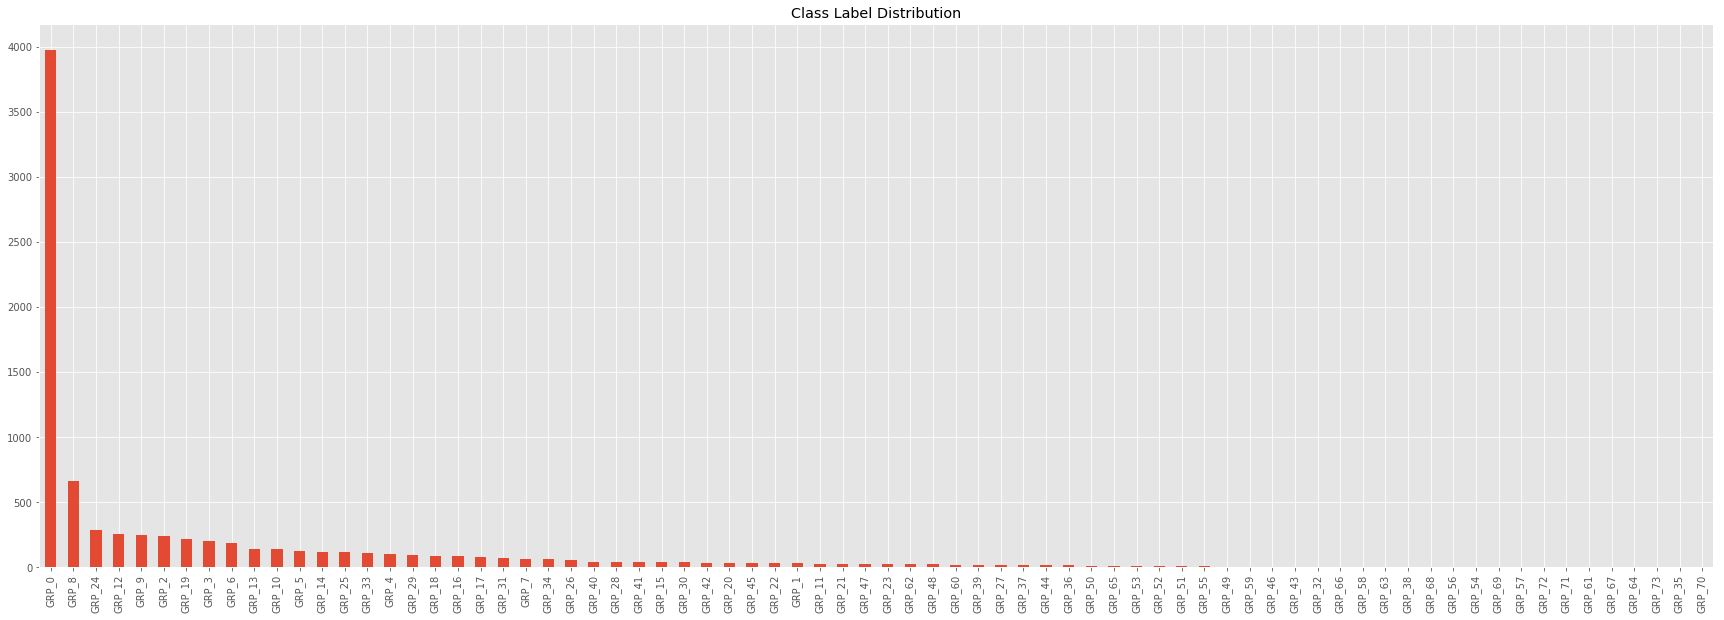

In [357]:
# Assignment group distribution
df['Assignment group'].value_counts().plot(kind='bar', figsize=(30,10), title='Class Label Distribution')

In [358]:
df.head()

,Short description,Description,Caller,Assignment group,Complete_Description,review_len,word_count
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,verified user details employee manager name ...,190,31
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,from hello team meetings skype meetings etc...,141,22
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,from cannot log to vpn best cant log to vpn,46,10
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable access tool page unable access tool page,47,8
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error,24,4


In [359]:
# The distribution of top unigrams before removing stop words for Complete_Description

from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]



common_words = get_top_n_words(df['Complete_Description'], 20)
for word, freq in common_words:
    print(word, freq)
# df1 = pd.DataFrame(common_words, columns = ['Description' , 'count'])
# df1.groupby('Description').sum()['count'].sort_values(ascending=False).iplot(
#     kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review before removing stop words')


the 7049
job 5060
from 3590
not 2946
and 2766
for 2655
password 2383
please 2183
erp 2096
yes 2027
scheduler 1928
tool 1762
failed 1735
company 1588
na 1575
sid 1552
reset 1530
this 1524
unable 1498
user 1478


In [360]:
# The distribution of top unigrams after removing stop words for Complete_Description

def get_top_n_words(corpus, range=(1,1), n=None):
    vec = CountVectorizer(ngram_range=range, stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(df['Complete_Description'], (1,1),20)
for word, freq in common_words:
    print(word, freq)
# df1 = pd.DataFrame(common_words, columns = ['Description' , 'count'])
# df1.groupby('Description').sum()['count'].sort_values(ascending=False).iplot(
#     kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review before removing stop words')


job 5060
password 2383
erp 2096
yes 2027
scheduler 1928
tool 1762
failed 1735
company 1588
na 1575
sid 1552
reset 1530
unable 1498
user 1478
access 1425
issue 1312
account 1211
ticket 1204
error 1025
hostname 971
outlook 948


In [361]:
# The distribution of top bigrams after removing stop words for Complete_Description

common_words = get_top_n_words(df['Complete_Description'], (2,2),20)
for word, freq in common_words:
    print(word, freq)

job scheduler 1928
failed job 1614
yes na 1570
job job 1269
scheduler job 983
job failed 952
password reset 797
erp sid 602
backup circuit 441
engineering tool 427
account locked 400
collaboration platform 356
reset password 337
telecom vendor 323
password management 312
management tool 311
ticket update 300
abended job 300
type outage 286
scheduled maintenance 286


In [362]:
# The distribution of top trigrams after removing stop words for Complete_Description

common_words = get_top_n_words(df['Complete_Description'], (3,3) ,20)
for word, freq in common_words:
    print(word, freq)

failed job scheduler 1614
job scheduler job 983
job job failed 950
job failed job 950
scheduler job job 480
password management tool 311
job job scheduler 300
abended job job 298
yes na company 285
backup circuit yes 285
yes yes na 231
erp sid account 213
management tool password 213
src inside dst 185
access group acl 185
group acl inside 185
circuit yes na 175
browser microsoft internet 168
microsoft internet explorer 168
internet explorer email 168



### Stopwords Removal & Lemmetization

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

Text preprocessing includes both Stemming as well as Lemmatization. Many times people find these two terms confusing. Some treat these two as same. Actually, lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.

In [363]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords,wordnet
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer

In [364]:
# # Download Wordnet through NLTK in python console:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jdeshpande/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jdeshpande/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jdeshpande/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jdeshpande/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [365]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

processed_all_documents = []
for row in df['Complete_Description']:
    word_tokens = word_tokenize(row)
#     print(word_tokens)

    filtered_sentence = [] 

    # Removing Stopwords
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    
    # Lemmetization
    lemma_word = []
    wordnet_lemmatizer = WordNetLemmatizer()
    for w in filtered_sentence:
        word = wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w))
        lemma_word.append(word)
    words = ' '.join(lemma_word)
    processed_all_documents.append(words)

In [366]:
df['Clean_Description'] = processed_all_documents

In [367]:
df.head()

,Short description,Description,Caller,Assignment group,Complete_Description,review_len,word_count,Clean_Description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,verified user details employee manager name ...,190,31,verify user detail employee manager name check...
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,from hello team meetings skype meetings etc...,141,22,hello team meeting skype meeting etc appear ou...
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,from cannot log to vpn best cant log to vpn,46,10,log vpn best cant log vpn
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable access tool page unable access tool page,47,8,unable access tool page unable access tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error,24,4,skype error skype error


In [368]:
# Adding Word count and Description Length
df['clean_review_len'] = df['Clean_Description'].astype(str).apply(len)
df['clean_word_count'] = df['Clean_Description'].apply(lambda x: len(str(x).split()))

In [369]:
df.head()

,Short description,Description,Caller,Assignment group,Complete_Description,review_len,word_count,Clean_Description,clean_review_len,clean_word_count
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,verified user details employee manager name ...,190,31,verify user detail employee manager name check...,152,24
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,from hello team meetings skype meetings etc...,141,22,hello team meeting skype meeting etc appear ou...,104,15
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,from cannot log to vpn best cant log to vpn,46,10,log vpn best cant log vpn,25,6
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable access tool page unable access tool page,47,8,unable access tool page unable access tool page,47,8
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error,24,4,skype error skype error,23,4


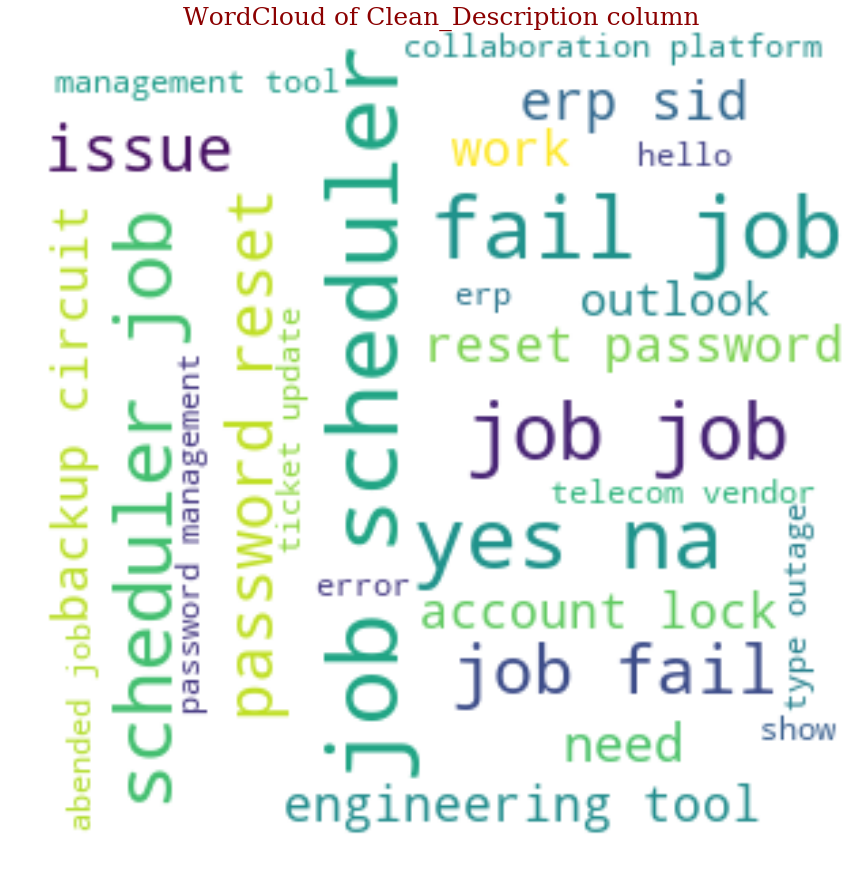

In [370]:
word_cloud_visulization(df['Clean_Description'], "Clean_Description", stopword=True)

### Label Encoding

Label Encoding refers to converting the labels into numeric form so as to convert it into the machine-readable form. Machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.

Label Encoding Assignment group	

In [371]:
df['Assignment group'].unique() 

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

In [372]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
df['Assignment group LabelEncode']= label_encoder.fit_transform(df['Assignment group']) 
  
df['Assignment group LabelEncode'].unique() 

array([ 0,  1, 23, 34, 45, 56, 67, 72, 73,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28,
       29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 26, 59, 60, 61, 62, 63, 64,
       65, 66, 68, 69, 70, 71])

In [373]:
df.head(10)

,Short description,Description,Caller,Assignment group,Complete_Description,review_len,word_count,Clean_Description,clean_review_len,clean_word_count,Assignment group LabelEncode
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,verified user details employee manager name ...,190,31,verify user detail employee manager name check...,152,24,0
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,from hello team meetings skype meetings etc...,141,22,hello team meeting skype meeting etc appear ou...,104,15,0
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,from cannot log to vpn best cant log to vpn,46,10,log vpn best cant log vpn,25,6,0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable access tool page unable access tool page,47,8,unable access tool page unable access tool page,47,8,0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error,24,4,skype error skype error,23,4,0
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,unable log to engineering tool and skype unabl...,81,14,unable log engineering tool skype unable log e...,67,10,0
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,event critical hostname company com the value...,211,31,event critical hostname company com value moun...,187,27,1
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0,ticket employment status new non employee ent...,118,18,ticket employment status new non employee ente...,115,18,0
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,unable disable add ins outlook unable disable ...,61,10,unable disable add in outlook unable disable a...,59,10,0
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0,ticket update inplant ticket update inplant,44,6,ticket update inplant ticket update inplant,43,6,0


### Need of feature extraction techniques
Machine Learning algorithms learn from a pre-defined set of features from the training data to produce output for the test data. But the main problem in working with language processing is that machine learning algorithms cannot work on the raw text directly. So, we need some feature extraction techniques to convert text into a matrix(or vector) of features.
Some of the most popular methods of feature extraction are :

Bag-of-Words

TF-IDF

### Term Frequency-Inverse Document Frequency (TF-IDF)

“Term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.”

In [374]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix, classification_report


tfidf = TfidfVectorizer()
x_tfidf = tfidf.fit_transform(df['Clean_Description']).toarray()


In [375]:
x_tfidf.shape

(8500, 12233)

In [376]:
x_tfidf[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [377]:
y = df['Assignment group LabelEncode']

In [378]:
y.shape

(8500,)

In [379]:
train_x, test_x, train_y, test_y = train_test_split(x_tfidf, y, test_size=0.3)

### ML Classifier

 #### Support Vector Machine

In [500]:
from sklearn.svm import SVC
clf = SVC(kernel='linear').fit(train_x, train_y)
y_pred = clf.predict(test_x)
acc_score = accuracy_score(test_y, y_pred)
print("SVM-Linear Score: ", acc_score)
f_sc = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("SVM F1 Score: ", f_sc)

SVM-Linear Score:  0.648235294117647
SVM F1 Score:  0.6175761919340252


#### Naive Bayes

In [501]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)
acc_score = accuracy_score(test_y, y_pred)
print("Naive Bayes Score: ", acc_score)
f_sc = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("Naive Bayes F1 Score: ", f_sc)

Naive Bayes Score:  0.5447058823529412
Naive Bayes F1 Score:  0.6285878765351199


#### Random forest

In [95]:
from sklearn.ensemble import RandomForestClassifier

rfcl = RandomForestClassifier(n_estimators=150, random_state=50, bootstrap=False)
rfcl = rfcl.fit(train_x, train_y)
pred_RF = rfcl.predict(test_x)
acc_RF = accuracy_score(test_y, pred_RF)
print("Random forest Accuracy Score {}".format(acc_RF))

Random forest Accuracy Score 0.6607843137254902


#### Deeplearning : ANN

In [380]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [381]:
df.head()

,Short description,Description,Caller,Assignment group,Complete_Description,review_len,word_count,Clean_Description,clean_review_len,clean_word_count,Assignment group LabelEncode
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,verified user details employee manager name ...,190,31,verify user detail employee manager name check...,152,24,0
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,from hello team meetings skype meetings etc...,141,22,hello team meeting skype meeting etc appear ou...,104,15,0
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,from cannot log to vpn best cant log to vpn,46,10,log vpn best cant log vpn,25,6,0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable access tool page unable access tool page,47,8,unable access tool page unable access tool page,47,8,0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error,24,4,skype error skype error,23,4,0


#### Binning the posts by word count.¶
Ideally we would want to know how many posts are short, medium and large posts. Binning is a technique is efficient mechanism to do that

In [384]:
bins=[0,50,75, np.inf]
df['bins']=pd.cut(df.clean_word_count, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])

In [390]:
df.head(10)

,Short description,Description,Caller,Assignment group,Complete_Description,review_len,word_count,Clean_Description,clean_review_len,clean_word_count,Assignment group LabelEncode,bins
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,verified user details employee manager name ...,190,31,verify user detail employee manager name check...,152,24,0,0-100
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,from hello team meetings skype meetings etc...,141,22,hello team meeting skype meeting etc appear ou...,104,15,0,0-100
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,from cannot log to vpn best cant log to vpn,46,10,log vpn best cant log vpn,25,6,0,0-100
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable access tool page unable access tool page,47,8,unable access tool page unable access tool page,47,8,0,0-100
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error,24,4,skype error skype error,23,4,0,0-100
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,unable log to engineering tool and skype unabl...,81,14,unable log engineering tool skype unable log e...,67,10,0,0-100
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,event critical hostname company com the value...,211,31,event critical hostname company com value moun...,187,27,1,0-100
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0,ticket employment status new non employee ent...,118,18,ticket employment status new non employee ente...,115,18,0,0-100
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,unable disable add ins outlook unable disable ...,61,10,unable disable add in outlook unable disable a...,59,10,0,0-100
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0,ticket update inplant ticket update inplant,44,6,ticket update inplant ticket update inplant,43,6,0,0-100


In [386]:
word_distribution = df.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [387]:
word_distribution.head()

,bins,counts
0,0-100,8301
1,100-300,135
2,300-500,9
3,500-800,15
4,>800,1


Text(0.5, 1.0, 'Word distribution per bin')

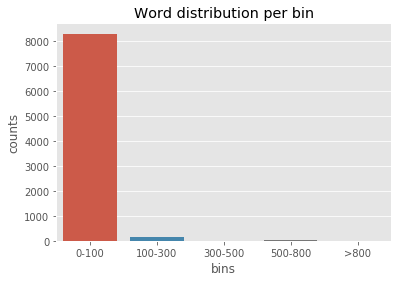

In [388]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [389]:
num_class = len(np.unique(df['Assignment group'].values))
y = df['Assignment group LabelEncode'].values

#### Tokenize the input¶
For a deep learning model we need to know what the input sequence length for our model should be. The distribution graph about shows us that for we have more posts with more than 100 words and less than 300 words.

Given the above information we can set the Input sequence length to be max(words per post). By doing so we are essentially wasting a lot of resources so we make a tradeoff and set the the Input sequence length to 500

In [391]:
MAX_LENGTH = 800
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.Clean_Description.values)
post_seq = tokenizer.texts_to_sequences(df.Clean_Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [392]:
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05)

In [393]:
vocab_size = len(tokenizer.word_index) + 1

In [394]:
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
x = Flatten()(embedding_layer)
x = Dense(32, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.2, 
          shuffle=True, epochs=10, callbacks=[checkpointer])

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 800)               0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 800, 128)          1568640   
_________________________________________________________________
flatten_10 (Flatten)         (None, 102400)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)                3276832   
_________________________________________________________________
dense_39 (Dense)             (None, 74)                2442      
Total params: 4,847,914
Trainable params: 4,847,914
Non-trainable params: 0
_________________________________________________________________


/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6460 samples, validate on 1615 samples
Epoch 1/10
6460/6460 [==============================] - 7s 1ms/step - loss: 2.6821 - acc: 0.4596 - val_loss: 2.3132 - val_acc: 0.4675

Epoch 00001: val_acc improved from -inf to 0.46749, saving model to weights-simple.hdf5
Epoch 2/10
6460/6460 [==============================] - 7s 1ms/step - loss: 2.0936 - acc: 0.5282 - val_loss: 2.0588 - val_acc: 0.5375

Epoch 00002: val_acc improved from 0.46749 to 0.53746, saving model to weights-simple.hdf5
Epoch 3/10
6460/6460 [==============================] - 7s 1ms/step - loss: 1.8118 - acc: 0.5556 - val_loss: 1.9321 - val_acc: 0.5585

Epoch 00003: val_acc improved from 0.53746 to 0.55851, saving model to weights-simple.hdf5
Epoch 4/10
6460/6460 [==============================] - 7s 1ms/step - loss: 1.5598 - acc: 0.5997 - val_loss: 1.7885 - val_acc: 0.5746

Epoch 00004: val_acc improved from 0.55851 to 0.57461, saving model to weights-simple.hdf5
Epoch 5/10
6460/6460 [=============================

In [395]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.6564705882352941

#### Deeplearning : RNN

In [332]:
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)

x = LSTM(64)(embedding_layer)
x = Dense(32, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 300)               0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 300, 128)          1568640   
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_37 (Dense)             (None, 74)                2442      
Total params: 1,622,570
Trainable params: 1,622,570
Non-trainable params: 0
_________________________________________________________________


In [333]:
filepath="weights.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=10, callbacks=[checkpointer])

/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6056 samples, validate on 2019 samples
Epoch 1/10
6056/6056 [==============================] - 16s 3ms/step - loss: 2.9472 - acc: 0.4653 - val_loss: 2.3392 - val_acc: 0.5250

Epoch 00001: val_acc improved from -inf to 0.52501, saving model to weights.hdf5
Epoch 2/10
6056/6056 [==============================] - 17s 3ms/step - loss: 2.0758 - acc: 0.5441 - val_loss: 2.0583 - val_acc: 0.5250

Epoch 00002: val_acc did not improve from 0.52501
Epoch 3/10
6056/6056 [==============================] - 17s 3ms/step - loss: 1.7775 - acc: 0.5771 - val_loss: 1.9078 - val_acc: 0.5622

Epoch 00003: val_acc improved from 0.52501 to 0.56216, saving model to weights.hdf5
Epoch 4/10
6056/6056 [==============================] - 17s 3ms/step - loss: 1.5321 - acc: 0.6204 - val_loss: 1.8244 - val_acc: 0.5681

Epoch 00004: val_acc improved from 0.56216 to 0.56810, saving model to weights.hdf5
Epoch 5/10
6056/6056 [==============================] - 19s 3ms/step - loss: 1.3375 - acc: 0.6527 - val_loss:

In [334]:
accuracy_score(y_test, predicted)

0.64